In [1]:
import os
import csv

root = "/root/FFPP"   # FFPP 루트
output_tsv = os.path.join(root, "metadata.tsv")

subsets = ["image_subset", "mp4_subset"]
fake_folders = ["Deepfakes", "Face2Face", "FaceSwap"]

rows = []

for subset in subsets:
    subset_path = os.path.join(root, subset)

    for folder in os.listdir(subset_path):
        folder_path = os.path.join(subset_path, folder)
        if not os.path.isdir(folder_path):
            continue

        # real / fake 라벨
        label = "real" if folder == "original" else "fake"

        for fname in os.listdir(folder_path):
            fpath = os.path.join(folder_path, fname)

            # 확장자 분기
            if fname.lower().endswith(".mp4"):
                modality = "video"
            elif fname.lower().endswith((".png", ".jpg", ".jpeg")):
                modality = "image"
            else:
                continue

            rows.append([fpath, label, modality])

# 파일 저장
with open(output_tsv, "w", newline="", encoding="utf-8") as f:
    writer = csv.writer(f, delimiter="\t")
    writer.writerow(["path", "label", "modality"])
    writer.writerows(rows)

print("Saved:", output_tsv)


Saved: /root/FFPP/metadata.tsv


/root/FFPP/mp4_subset/FaceSwap/384_932.mp4 -> 1 face(s) detected


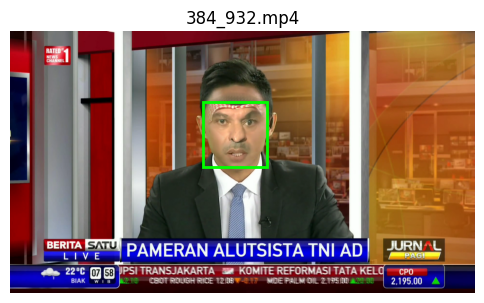

/root/FFPP/mp4_subset/original/375.mp4 -> 1 face(s) detected


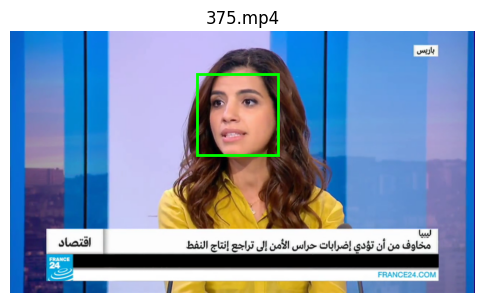

/root/FFPP/mp4_subset/Face2Face/999_960.mp4 -> 1 face(s) detected


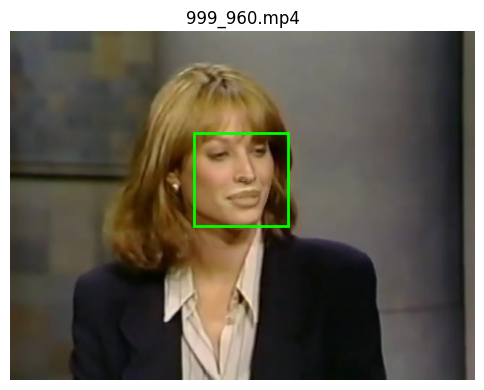

/root/FFPP/mp4_subset/Deepfakes/476_400.mp4 -> 1 face(s) detected


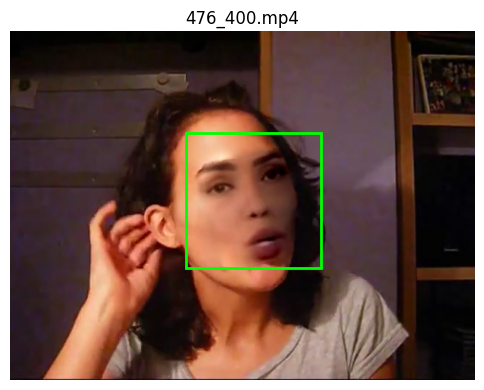

/root/FFPP/mp4_subset/Face2Face/908_207.mp4 -> 1 face(s) detected


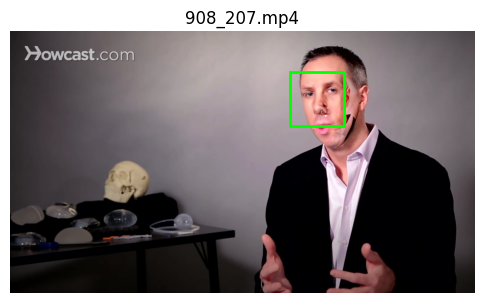

/root/FFPP/mp4_subset/Face2Face/869_780.mp4 -> 6 face(s) detected


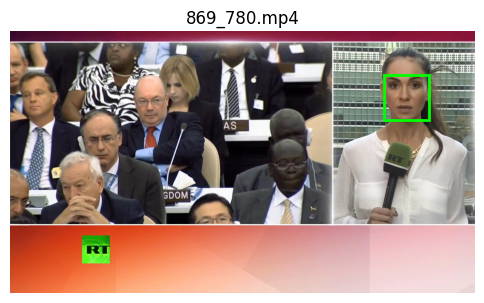

/root/FFPP/mp4_subset/Deepfakes/539_499.mp4 -> 1 face(s) detected


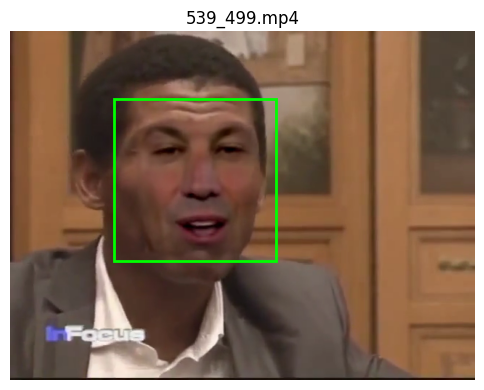

/root/FFPP/mp4_subset/FaceSwap/789_753.mp4 -> 1 face(s) detected


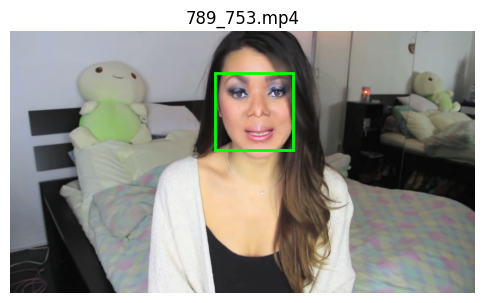

/root/FFPP/mp4_subset/original/120.mp4 -> 1 face(s) detected


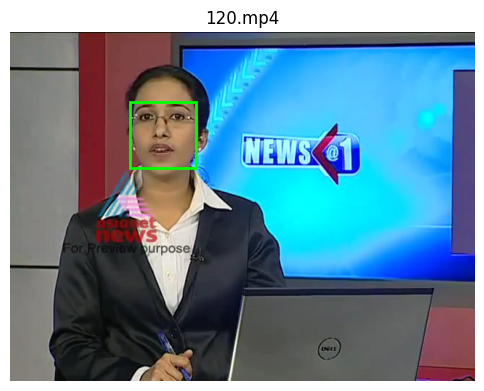

/root/FFPP/mp4_subset/Face2Face/976_954.mp4 -> 1 face(s) detected


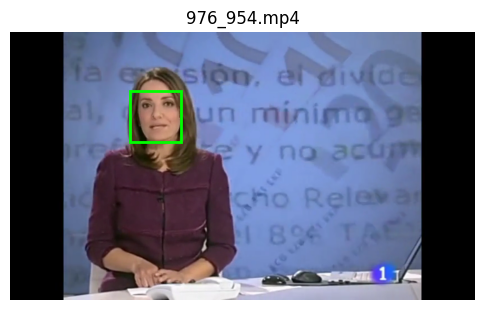

In [2]:
# dlib 얼굴 크롭 확인용 셀
import random
from pathlib import Path

import cv2
import dlib
import matplotlib.pyplot as plt
import pandas as pd

meta_path = "/root/FFPP/metadata.tsv"
df = pd.read_csv(meta_path, sep="\t")

# 비디오 행만 필터
if "modality" in df.columns:
    vid_df = df[df["modality"].str.contains("video", case=False, na=False)]
else:
    vid_df = df[df["path"].str.endswith(".mp4")]

samples = vid_df.sample(10, random_state=42)
detector = dlib.get_frontal_face_detector()

def load_mid_frame(video_path: str):
    cap = cv2.VideoCapture(video_path)
    total = int(cap.get(cv2.CAP_PROP_FRAME_COUNT) or 0)
    cap.set(cv2.CAP_PROP_POS_FRAMES, max(0, total // 2))
    ok, frame = cap.read()
    cap.release()
    if not ok or frame is None:
        return None
    return cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

for _, row in samples.iterrows():
    vpath = str(row["path"])
    frame = load_mid_frame(vpath)
    if frame is None:
        print(f"[SKIP] cannot read frame: {vpath}")
        continue

    faces = detector(frame, 1)
    print(f"{vpath} -> {len(faces)} face(s) detected")

    # 가장 큰 얼굴만 시각화
    if faces:
        face = max(faces, key=lambda r: r.width() * r.height())
        x1, y1, x2, y2 = face.left(), face.top(), face.right(), face.bottom()
        plt.figure(figsize=(6, 6))
        plt.imshow(frame)
        plt.gca().add_patch(plt.Rectangle((x1, y1), x2 - x1, y2 - y1,
                                          fill=False, edgecolor="lime", linewidth=2))
        plt.title(Path(vpath).name)
        plt.axis("off")
        plt.show()


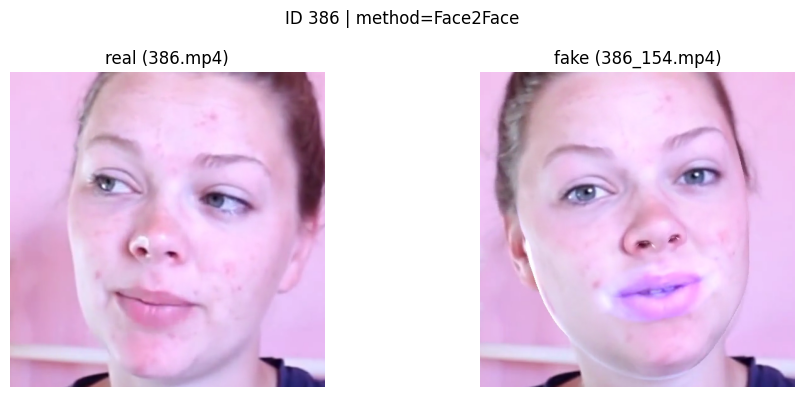

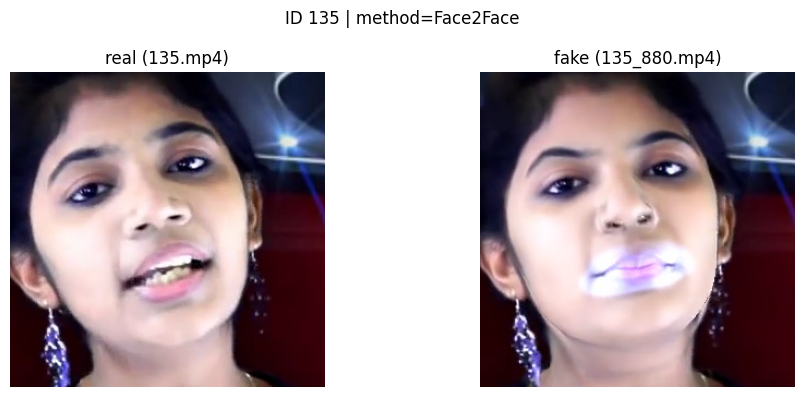

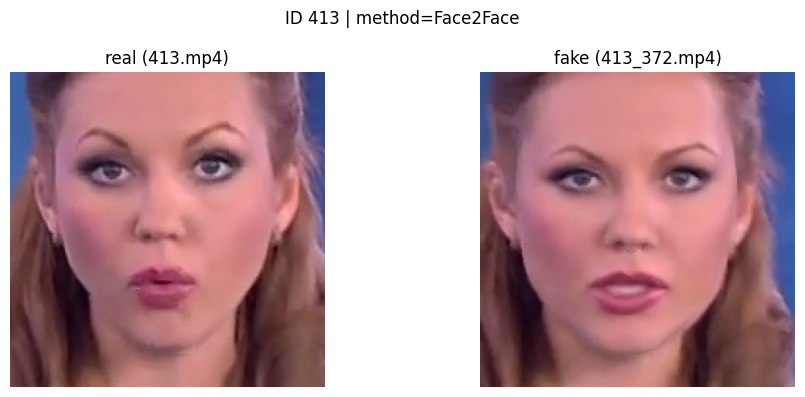

In [7]:
# FFPP real/fake paired 얼굴 크롭 확인 셀
import random
from pathlib import Path
import cv2, dlib, numpy as np, pandas as pd, matplotlib.pyplot as plt

meta_path = "/root/FFPP/metadata.tsv"
df = pd.read_csv(meta_path, sep="\t")
vid_df = df[df["modality"].str.contains("video", case=False, na=False)]

fake_method = "Face2Face"  # Deepfakes/FaceSwap/NeuralTextures 등으로 교체 가능
fake_df = vid_df[vid_df["path"].str.contains(f"/{fake_method}/")]

def base_id(path: str):
    # e.g., .../Face2Face/001_870.mp4 -> "001"
    return Path(path).stem.split("_")[0]

samples = fake_df.sample(min(3, len(fake_df)), random_state=42)
pairs = []
for _, row in samples.iterrows():
    bid = base_id(row["path"])
    real_path = f"/root/FFPP/mp4_subset/original/{bid}.mp4"
    if Path(real_path).exists():
        pairs.append((real_path, row["path"], bid))

detector = dlib.get_frontal_face_detector()

def load_mid_frame(p):
    cap = cv2.VideoCapture(p)
    total = int(cap.get(cv2.CAP_PROP_FRAME_COUNT) or 0)
    cap.set(cv2.CAP_PROP_POS_FRAMES, max(0, total // 2))
    ok, frame = cap.read(); cap.release()
    return None if not ok or frame is None else cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

def crop_face(img, rect, scale=1.3):
    h, w = img.shape[:2]
    x1, y1, x2, y2 = rect.left(), rect.top(), rect.right(), rect.bottom()
    size = int(max(x2 - x1, y2 - y1) * scale)
    cx, cy = (x1 + x2)//2, (y1 + y2)//2
    x1 = max(cx - size//2, 0); y1 = max(cy - size//2, 0)
    x2 = min(x1 + size, w); y2 = min(y1 + size, h)
    return img[y1:y2, x1:x2]

for real_p, fake_p, bid in pairs:
    frames = []
    for p in [real_p, fake_p]:
        f = load_mid_frame(p)
        if f is None:
            frames.append((p, None, None)); continue
        faces = detector(f, 1)
        if not faces:
            frames.append((p, f, None)); continue
        face = max(faces, key=lambda r: r.width()*r.height())
        frames.append((p, f, crop_face(f, face, scale=1.3)))

    plt.figure(figsize=(10, 4))
    plt.suptitle(f"ID {bid} | method={fake_method}")
    for i, (p, orig, crop) in enumerate(frames):
        label = "real" if i == 0 else "fake"
        if orig is None:
            plt.subplot(1, 2, i+1); plt.axis("off"); plt.title(f"{label}: failed to read"); continue
        plt.subplot(1, 2, i+1); plt.imshow(crop if crop is not None else orig); plt.axis("off")
        plt.title(f"{label} ({Path(p).name})")
    plt.tight_layout(); plt.show()


In [7]:
# test_data 이미지 추론 (checkpoint-3000)
import os
from pathlib import Path
import torch
from torch.utils.data import DataLoader
from datasets import Dataset
from src import ClipBackbone, LNCLIPDF, build_media_transforms, get_clip_processor, collate_fn

# 1) 입력 파일 준비
test_dir = Path("/root/Jiwon/Deepfake_killer-Video-image/test_data")
img_paths = sorted([str(p) for p in test_dir.glob("*") if p.suffix.lower() in [".png", ".jpg", ".jpeg"]])
ds = Dataset.from_dict({"image": img_paths, "label": [0]*len(img_paths)})  # dummy label

# 2) 전처리/크롭 변환 (평가용)
processor = get_clip_processor("openai/clip-vit-large-patch14")
_, val_tfm = build_media_transforms(
    processor,
    image_key="image",
    video_key=None,
    do_face_crop=True,
    rotation_deg=15,
    num_frames=1,
    num_frames_val=1,
    video_strategy="uniform",
)
ds.set_transform(val_tfm)

# 3) 모델 로드 (checkpoint-3000)
ckpt_dir = "/root/Jiwon/Deepfake_killer-Video-image/outputs_video/checkpoint-33912"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dtype = torch.bfloat16 if device.type == "cuda" else torch.float32

backbone = ClipBackbone(
    model_name="openai/clip-vit-large-patch14",
    dtype="bf16" if device.type == "cuda" else "fp32",
    freeze_backbone=True,
    use_cls_token=True,
    train_layer_norm_only=True,
)
model = LNCLIPDF(
    backbone=backbone,
    num_classes=2,
    align_weight=0.1,
    uniform_weight=0.1,
    slerp_target=1024,
    classifier_hidden=512,
    class_weights=None,
)

state = torch.load(os.path.join(ckpt_dir, "pytorch_model.bin"), map_location=device)
_ = model.load_state_dict(state, strict=False)
model = model.to(device=device, dtype=dtype).eval()

# 4) 추론
loader = DataLoader(ds, batch_size=1, shuffle=False, collate_fn=collate_fn)
id2label = {0: "real", 1: "fake"}

results = []
with torch.no_grad():
    for i, batch in enumerate(loader):
        x = batch["pixel_values"].to(device)
        out = model(pixel_values=x, labels=None, apply_slerp=False, return_dict=True)
        logits = out["logits_for_loss"].float()
        probs = torch.softmax(logits, dim=-1).cpu().numpy()[0]
        pred_id = int(probs.argmax())
        results.append((img_paths[i], id2label[pred_id], probs))

for path, pred, prob in results:
    print(f"{Path(path).name}: pred={pred}, prob_real={prob[0]:.4f}, prob_fake={prob[1]:.4f}")


`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.


Yujin.png: pred=real, prob_real=0.8615, prob_fake=0.1385
dongil.png: pred=real, prob_real=0.8026, prob_fake=0.1974
jiwon1.jpg: pred=real, prob_real=0.9998, prob_fake=0.0002
jiwon2.png: pred=real, prob_real=0.7549, prob_fake=0.2451
jiwon3.jpg: pred=real, prob_real=0.6007, prob_fake=0.3993
karina.png: pred=real, prob_real=0.7599, prob_fake=0.2401
kwangsoo.png: pred=real, prob_real=0.9977, prob_fake=0.0023
sample_image_1.png: pred=real, prob_real=0.9728, prob_fake=0.0272
sample_image_2.png: pred=real, prob_real=0.8524, prob_fake=0.1476
sample_image_3.png: pred=fake, prob_real=0.3877, prob_fake=0.6123
sample_image_4.png: pred=real, prob_real=0.5412, prob_fake=0.4588
sample_image_5.png: pred=real, prob_real=0.9933, prob_fake=0.0067
sample_image_6.png: pred=real, prob_real=0.5868, prob_fake=0.4132
sample_image_7.png: pred=real, prob_real=0.9329, prob_fake=0.0671


In [5]:
# Inference data(real/fake) 평가 셀
import os
from pathlib import Path
import torch
from torch.utils.data import DataLoader
from datasets import Dataset
from src import ClipBackbone, LNCLIPDF, build_media_transforms, get_clip_processor, collate_fn

root = Path("/root/Jiwon/Deepfake_killer-Video-image")
data_dir = root / "Inference data"
ckpt_dir = root / "outputs_video/checkpoint-33912"

# 1) 파일 수집 (숨김파일 제외)
paths, labels = [], []
for lbl_name, lbl_id in [("real", 0), ("fake", 1)]:
    for p in sorted((data_dir / lbl_name).glob("*.png")):
        paths.append(str(p))
        labels.append(lbl_id)

ds = Dataset.from_dict({"image": paths, "label": labels})

# 2) 전처리(평가용, face crop 포함)
processor = get_clip_processor("openai/clip-vit-large-patch14")
_, val_tfm = build_media_transforms(
    processor,
    image_key="image",
    video_key=None,
    do_face_crop=True,
    rotation_deg=15,
    num_frames=1,
    num_frames_val=1,
    video_strategy="uniform",
)
ds.set_transform(val_tfm)

# 3) 모델 로드
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dtype = torch.bfloat16 if device.type == "cuda" else torch.float32

backbone = ClipBackbone(
    model_name="openai/clip-vit-large-patch14",
    dtype="bf16" if device.type == "cuda" else "fp32",
    freeze_backbone=True,
    use_cls_token=True,
    train_layer_norm_only=True,
)
model = LNCLIPDF(
    backbone=backbone,
    num_classes=2,
    align_weight=0.1,
    uniform_weight=0.1,
    slerp_target=1024,
    classifier_hidden=512,
    class_weights=None,
)

state = torch.load(ckpt_dir / "pytorch_model.bin", map_location=device)
_ = model.load_state_dict(state, strict=False)
model = model.to(device=device, dtype=dtype).eval()

# 4) 추론 및 정확도
loader = DataLoader(ds, batch_size=2, shuffle=False, collate_fn=collate_fn)
id2label = {0: "real", 1: "fake"}

total = correct = 0
per_class = {0: [0, 0], 1: [0, 0]}  # correct, total
results = []

with torch.no_grad():
    for i, batch in enumerate(loader):
        x = batch["pixel_values"].to(device)
        y = batch["labels"]
        out = model(pixel_values=x, labels=None, apply_slerp=False, return_dict=True)
        logits = out["logits_for_loss"].float()  # softmax용 FP32
        probs = torch.softmax(logits, dim=-1).cpu()
        preds = probs.argmax(dim=-1)

        for j in range(len(preds)):
            idx = i * loader.batch_size + j
            path = paths[idx]
            pred_id = int(preds[j])
            label_id = int(y[j])
            total += 1
            correct += int(pred_id == label_id)
            per_class[label_id][1] += 1
            per_class[label_id][0] += int(pred_id == label_id)
            results.append((Path(path).name, id2label[pred_id], probs[j].tolist()))

for fname, pred, prob in results:
    print(f"{fname}: pred={pred}, prob_real={prob[0]:.4f}, prob_fake={prob[1]:.4f}")

print(f"\nOverall acc: {correct}/{total} = {correct/total:.4f}")
for cid, (c_ok, c_tot) in per_class.items():
    acc = c_ok / c_tot if c_tot else 0
    print(f"{id2label[cid]} acc: {c_ok}/{c_tot} = {acc:.4f}")


`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.


real-01.png: pred=real, prob_real=0.5910, prob_fake=0.4090
real-02.png: pred=real, prob_real=0.9724, prob_fake=0.0276
real-03.png: pred=real, prob_real=0.9390, prob_fake=0.0610
real-04.png: pred=fake, prob_real=0.0798, prob_fake=0.9202
real-05.png: pred=real, prob_real=0.9367, prob_fake=0.0633
real-06.png: pred=real, prob_real=0.9744, prob_fake=0.0256
real-07.png: pred=fake, prob_real=0.1152, prob_fake=0.8848
real-08.png: pred=fake, prob_real=0.1987, prob_fake=0.8013
real-09.png: pred=fake, prob_real=0.4854, prob_fake=0.5146
real-10.png: pred=fake, prob_real=0.4698, prob_fake=0.5302
fake-01.png: pred=real, prob_real=0.5780, prob_fake=0.4220
fake-02.png: pred=real, prob_real=0.9992, prob_fake=0.0008
fake-03.png: pred=real, prob_real=0.9718, prob_fake=0.0282
fake-04.png: pred=fake, prob_real=0.4275, prob_fake=0.5725
fake-05.png: pred=real, prob_real=0.7461, prob_fake=0.2539
fake-06.png: pred=real, prob_real=0.9363, prob_fake=0.0637
fake-07.png: pred=fake, prob_real=0.0034, prob_fake=0.99

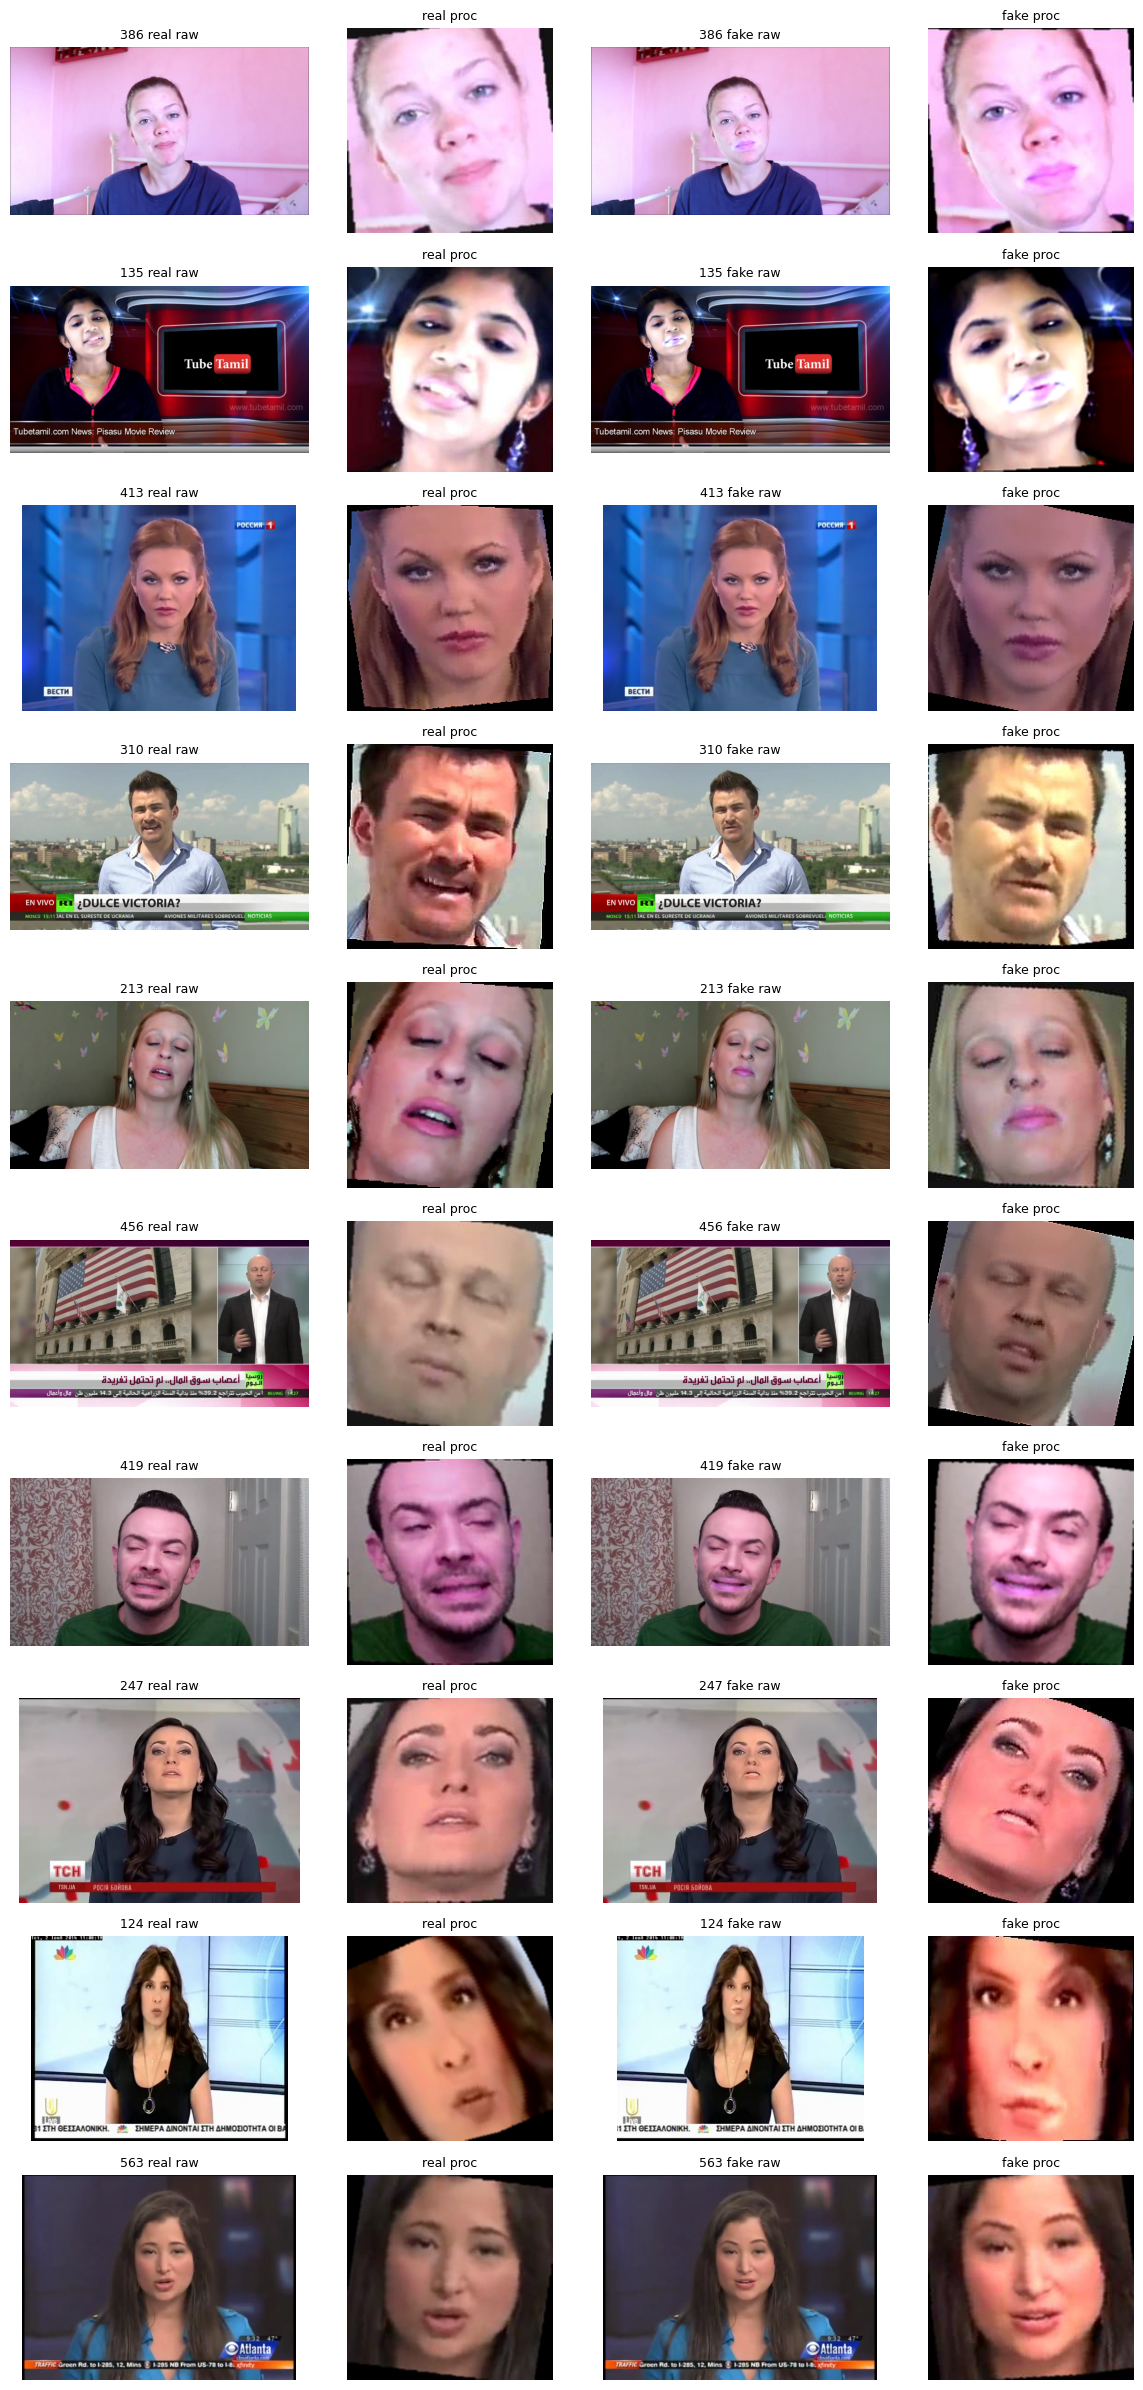

In [14]:
# FFPP 비디오 프레임 샘플링(학습과 동일) 시각화 셀
import math
from pathlib import Path
import numpy as np, pandas as pd, matplotlib.pyplot as plt
import torch
from src.processing.processors import sample_video_frames_to_pil, build_media_transforms, get_clip_processor

meta_path = "/root/FFPP/metadata.tsv"
fake_method = "Face2Face"   # Deepfakes/FaceSwap/NeuralTextures 등으로 교체 가능
n_rows = 10                 # 페어 수(행)
video_root = Path("/root/FFPP/mp4_subset")

# 메타데이터 로드 후 영상만 필터
df = pd.read_csv(meta_path, sep="\t")
vid_df = df[df["modality"].str.contains("video", case=False, na=False)]

# fake 메서드별 샘플과 같은 ID의 real 매칭
fake_df = vid_df[vid_df["path"].str.contains(f"/{fake_method}/")]
def base_id(p): return Path(p).stem.split("_")[0]
pairs = []
for _, row in fake_df.sample(min(n_rows, len(fake_df)), random_state=42).iterrows():
    bid = base_id(row["path"])
    real_p = video_root / "original" / f"{bid}.mp4"
    if real_p.exists():
        pairs.append((str(real_p), row["path"], bid))

# 학습용 변환 준비 (num_frames=1, uniform, face crop 포함)
processor = get_clip_processor("openai/clip-vit-large-patch14")
train_tfm, _ = build_media_transforms(
    processor,
    image_key=None,
    video_key="video_path",
    do_face_crop=True,
    rotation_deg=15,
    num_frames=1,
    num_frames_val=1,
    video_strategy="uniform",
)
mean, std = map(torch.tensor, (processor.image_mean, processor.image_std))

def denorm_to_pil(t):
    # t: (3,H,W) Tensor -> PIL
    t = t.cpu() * std[:, None, None] + mean[:, None, None]
    t = torch.clamp(t, 0, 1)
    arr = (t.numpy().transpose(1,2,0) * 255).astype(np.uint8)
    return arr

def sample_and_transform(path):
    # raw frame
    frames = sample_video_frames_to_pil(path, num_frames=1, strategy="uniform")
    raw = np.array(frames[0]) if frames else None
    # transform 적용
    ex = {"video_path": [path], "label": [0]}
    out = train_tfm(ex)
    ten = out["pixel_values"][0]  # (T,3,H,W) or (3,H,W) depending on output
    if ten.ndim == 4:
        ten = ten[0]
    proc = denorm_to_pil(ten)
    return raw, proc

# 플롯
plt.figure(figsize=(12, 2.4 * len(pairs)))
for idx, (real_p, fake_p, bid) in enumerate(pairs):
    real_raw, real_proc = sample_and_transform(real_p)
    fake_raw, fake_proc = sample_and_transform(fake_p)
    for col, (img, title) in enumerate([
        (real_raw, f"{bid} real raw"),
        (real_proc, "real proc"),
        (fake_raw, f"{bid} fake raw"),
        (fake_proc, "fake proc"),
    ]):
        ax = plt.subplot(len(pairs), 4, idx*4 + col + 1)
        if img is None:
            ax.text(0.5, 0.5, "read fail", ha="center", va="center")
            ax.axis("off"); continue
        ax.imshow(img); ax.axis("off"); ax.set_title(title, fontsize=9)
plt.tight_layout()
plt.show()
